# Housing norm
> Regresión

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from functools import reduce

# https://xgboost.readthedocs.io/en/latest/python/python_api.html
import xgboost as xgb

# Cargar mi repo como paquete
from sklearn.datasets import load_boston
import sys
from os.path import abspath

try:
    from src.gaparsimony import GAparsimony
except:
    sys.path.append(abspath("C:/Users/Millan/Desktop/GAparsimony"))
    from src.gaparsimony import GAparsimony

In [4]:
df = pd.read_csv("../../data/housing_norm.csv")
print(df.shape)
df.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,class
0,0.000000,0.18,0.067815,0,0.314815,0.577505,0.641607,0.269203,0.000000,0.208015,0.287234,1.000000,0.089680,0.422222
1,0.000236,0.00,0.242302,0,0.172840,0.547998,0.782698,0.348962,0.043478,0.104962,0.553191,1.000000,0.204470,0.368889
2,0.000236,0.00,0.242302,0,0.172840,0.694386,0.599382,0.348962,0.043478,0.104962,0.553191,0.989737,0.063466,0.660000
3,0.000293,0.00,0.063050,0,0.150206,0.658555,0.441813,0.448545,0.086957,0.066794,0.648936,0.994276,0.033389,0.631111
4,0.000705,0.00,0.063050,0,0.150206,0.687105,0.528321,0.448545,0.086957,0.066794,0.648936,1.000000,0.099338,0.693333


In [5]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

data_train = pd.DataFrame(X_train, columns=df.columns[:-1]).reset_index(drop=True)
data_test = pd.DataFrame(X_test, columns=df.columns[:-1]).reset_index(drop=True)

print(f"train: {data_train.shape} test: {data_test.shape}")

train: (404, 13) test: (102, 13)


In [6]:
data_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.168788,0.00,0.646628,0,0.471193,0.333972,0.972194,0.088307,1.000000,0.914122,0.808511,0.880428,0.639625
1,0.006981,0.00,0.281525,0,0.314815,0.435524,0.552008,0.306359,0.130435,0.229008,0.893617,0.996772,0.185982
2,0.000319,0.35,0.205279,0,0.108848,0.473271,0.210093,0.501150,0.000000,0.223282,0.457447,0.912628,0.168322
3,0.079174,0.00,0.646628,0,0.471193,0.487066,0.846550,0.081132,1.000000,0.914122,0.808511,0.005547,0.594923
4,0.008087,0.00,0.281525,0,0.314815,0.415022,0.685891,0.242514,0.130435,0.229008,0.893617,0.984997,0.263521


In [7]:
data_test.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.000961,0.0,0.131598,0,0.257202,0.547040,0.836251,0.137921,0.173913,0.208015,0.425532,0.996470,0.201711
1,0.000563,0.4,0.218109,1,0.127572,0.612569,0.308960,0.268076,0.130435,0.127863,0.531915,1.000000,0.049669
2,0.001117,0.0,1.000000,0,0.460905,0.464074,0.987642,0.067155,0.130435,1.000000,0.797872,0.982879,0.450883
3,0.000959,0.0,0.379399,0,0.057613,0.479785,0.050463,0.378079,0.130435,0.225191,0.702128,0.984896,0.104581
4,0.057141,0.0,0.646628,0,0.674897,0.524238,0.915551,0.112632,1.000000,0.914122,0.808511,0.970220,0.428808


In [8]:
def fitness_XGBoost(chromosome):
    # First two values in chromosome are 'C' & 'sigma' of 'svmRadial' method
    tuneGrid = {
                "n_estimators ": int(chromosome[0]),
                "max_depth": int(chromosome[1]),
                "min_child_weight": int(chromosome[2]),
                "reg_alpha": chromosome[3],
                "reg_lambda": chromosome[4],
                "subsample": chromosome[5],
                "colsample_bytree": chromosome[6],
                "learning_rate": 0.01,
                "random_state": 1234,
                "verbosity": 0}
    
    # Next values of chromosome are the selected features (TRUE if > 0.50)
    selec_feat = chromosome[7:]>0.50
    
    # Return -Inf if there is not selected features
    if np.sum(selec_feat)<1:
        return np.array([np.NINF, np.NINF, np.Inf])
    
    # Extract features from the original DB plus response (last column)
    data_train_model = data_train.loc[: , data_train.columns[selec_feat]] 
    data_test_model = data_test.loc[: , data_test.columns[selec_feat]] 
    
    # How to validate each individual
    # 'repeats' could be increased to obtain a more robust validation metric. Also,
    # 'number' of folds could be adjusted to improve the measure.
    train_control = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)

    # train the model
#     np.random.seed(1234)

    aux = xgb.XGBRegressor(**tuneGrid)

    model = cross_val_score(aux, data_train_model, y_train, scoring="neg_mean_squared_error", cv=train_control, n_jobs=-1)

    

    # Extract kappa statistics (the repeated k-fold CV and the kappa with the test DB)
    rmse_val = model.mean()

    model = xgb.XGBRegressor(**tuneGrid).fit(data_train_model, y_train)

    rmse_test = mean_squared_error(model.predict(data_test_model), y_test)
    # Obtain Complexity = Num_Features*1E6+Number of support vectors
    complexity = np.sum(selec_feat)*1E6 + len(model.get_booster().get_dump())
    
    # Return(validation score, testing score, model_complexity)
    return np.array([rmse_val, -rmse_test, complexity])

In [9]:
# Ranges of size and decay
min_param = np.array([10, 2, 1, 0., 0., 0.6, 0.8])
max_param = np.array([2000, 20, 20, 1., 1., 1., 1.])
names_param = ["n_estimators(nrounds)","max_depth", "min_child_weight", 
               "reg_alpha(lasso)", "reg_lambda(ridge)", "subsample",
               "colsample_bytree"]

# ga_parsimony can be executed with a different set of 'rerank_error' values
rerank_error = 0.01

In [10]:
GAparsimony_model = GAparsimony(fitness=fitness_XGBoost,
                                  min_param=min_param,
                                  max_param=max_param,
                                  names_param=names_param,
                                  nFeatures=len(df.columns[:-1]),
                                  names_features=df.columns[:-1],
                                  keep_history = True,
                                  rerank_error = rerank_error,
                                  popSize = 64,
                                  elitism = 16,
                                  maxiter = 100, early_stop=10,
                                  feat_thres=0.90, # Perc selected features in first generation
                                  feat_mut_thres=0.10, # Prob of a feature to be one in mutation
                                  parallel = True, seed_ini = 1234,
                                  verbose=GAparsimony.MONITOR)

In [11]:
GAparsimony_model.fit()

GA-PARSIMONY | iter = 0
  MeanVal = -0.0175573 |  ValBest = -0.0194655 |  TstBest = -0.018198  | ComplexBest = 9000100.0  | Time(min) = 3.1283997  

GA-PARSIMONY | iter = 1
  MeanVal = -0.0176343 |  ValBest = -0.0188093 |  TstBest = -0.016582  | ComplexBest = 8000100.0  | Time(min) = 3.4348648  

GA-PARSIMONY | iter = 2
  MeanVal = -0.0204196 |  ValBest = -0.0188676 |  TstBest = -0.0172821 | ComplexBest = 6000100.0  | Time(min) = 2.8196399  

GA-PARSIMONY | iter = 3
  MeanVal = -0.020476  |  ValBest = -0.018876  |  TstBest = -0.0187637 | ComplexBest = 4000100.0  | Time(min) = 2.4388552  

GA-PARSIMONY | iter = 4
  MeanVal = -0.0213814 |  ValBest = -0.0201518 |  TstBest = -0.0191161 | ComplexBest = 3000100.0  | Time(min) = 1.9948005  

GA-PARSIMONY | iter = 5
  MeanVal = -0.0223451 |  ValBest = -0.0202851 |  TstBest = -0.0172438 | ComplexBest = 1000100.0  | Time(min) = 1.8481871  

GA-PARSIMONY | iter = 6
  MeanVal = -0.0225302 |  ValBest = -0.0200245 |  TstBest = -0.0170984 | ComplexBe

In [12]:
GAparsimony_model.summary()

+------------------------------------+
|             GA-PARSIMONY           |
+------------------------------------+

GA-PARSIMONY settings:
 Number of Parameters      = 7
 Number of Features        = 13
 Population size           = 64
 Maximum of generations    = 100
 Number of early-stop gen. = 10
 Elitism                   = 16
 Crossover probability     = 0.8
 Mutation probability      = 0.1
 Max diff(error) to ReRank = 0.01
 Perc. of 1s in first popu.= 0.9
 Prob. to be 1 in mutation = 0.1

 Search domain = 
           n_estimators(nrounds)  max_depth  min_child_weight  \
Min_param                   10.0        2.0               1.0   
Max_param                 2000.0       20.0              20.0   

           reg_alpha(lasso)  reg_lambda(ridge)  subsample  colsample_bytree  \
Min_param               0.0                0.0        0.6               0.8   
Max_param               1.0                1.0        1.0               1.0   

           CRIM   ZN  INDUS  CHAS  NOX   RM  AGE

In [18]:
summary = GAparsimony_model.summary()
print(summary)

{'popSize': 64, 'maxiter': 100, 'early_stop': 10, 'rerank_error': 0.01, 'elitism': 16, 'nParams': 7, 'nFeatures': 13, 'pcrossover': 0.8, 'pmutation': 0.1, 'feat_thres': 0.9, 'feat_mut_thres': 0.1, 'not_muted': 3, 'domain': array([[1.e+01, 2.e+00, 1.e+00, 0.e+00, 0.e+00, 6.e-01, 8.e-01, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00,
        0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [2.e+03, 2.e+01, 2.e+01, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00,
        1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00,
        1.e+00, 1.e+00, 1.e+00, 1.e+00]]), 'suggestions': None, 'iter': 10, 'best_score': -0.014194288769262074, 'bestfitnessVal': -0.01941930547340053, 'bestfitnessTst': -0.016817297836211775, 'bestcomplexity': 1000100.0, 'minutes_total': 23.789134526252745, 'bestsolution': array([-1.94193055e-02, -1.68172978e-02,  1.00010000e+06,  5.86500523e+02,
        1.33278684e+01,  1.44802932e+01,  2.23530240e-02,  5.83069253e-02,
        6.28764071e-01

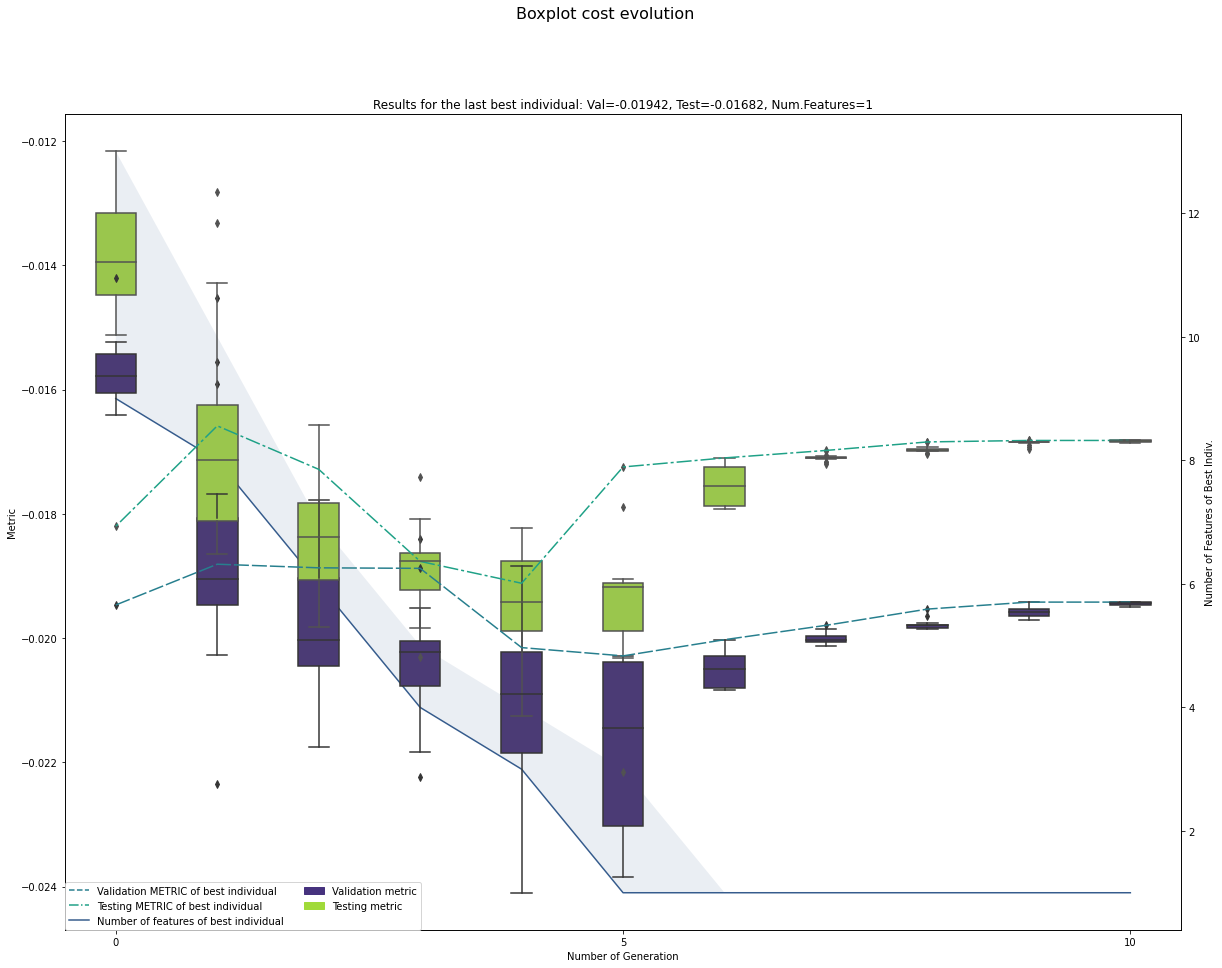

In [17]:
GAparsimony_model.plot(size_plot=(20,15))